# Implementing lognorm metallicity scatter into bagpipes' CEH
Following some experimentation in `Yirui_test_cube/simulation_info/read_star_particles_info.ipynb`, lognorm seems to be the best distribution to add to Bagpipes for the metallicity scatter in Yirui's simulated PSB. This is not intended to be a general solution, as the distribution is only informed by ONE simulation. But for the sake of fitting this simulation better, we do this first

In [1]:
import bagpipes as pipes
# setting bagpipes R_spec to as high as possible for perfect generation of models
pipes.config.R_spec = 4340
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from PyAstronomy import pyasl
import seaborn as sns
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
from scipy.optimize import curve_fit

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


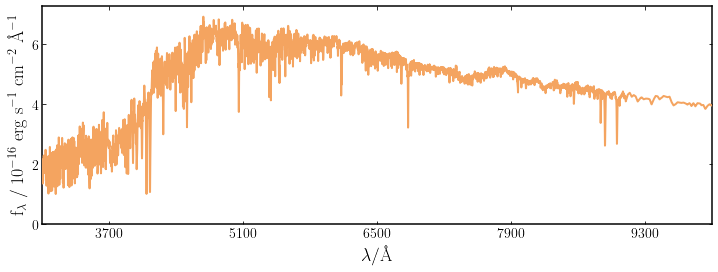

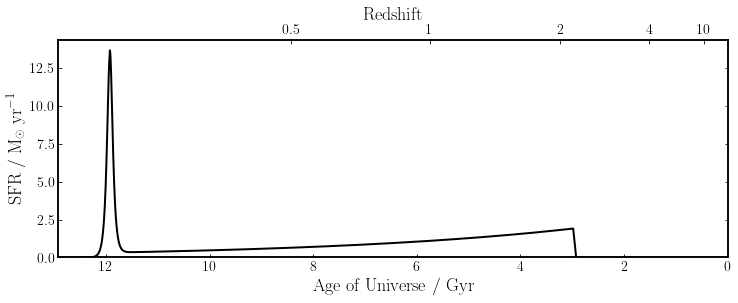

(<Figure size 864x288 with 2 Axes>,
 <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>)

In [4]:
# creating toy bagpipes models to extract inputs into chemical_enrichment_history.__init__ for later testing
# purposes
psb = {}
psb['massformed'] = 10
psb['metallicity'] = 1.0
psb['age'] = 10
psb['tau'] = 5
psb['burstage'] = 1
psb['alpha'] = 250
psb['beta'] = 250
psb['fburst'] = 0.2

model_components = {}
model_components['psb_wild2020'] = psb
model_components['redshift'] = 0.04

obs_wavs = np.arange(3000., 10000., 1.)
baseline_model = pipes.model_galaxy(model_components, spec_wavs=obs_wavs)
baseline_model.plot()
baseline_model.sfh.plot()

In [219]:
# adding lognorm to chemical_enrichment_history.py
import bagpipes.config as config

def __init__(self, model_comp, sfh_weights):

    self.zmet_vals = config.metallicities
    self.zmet_lims = config.metallicity_bins

    self.grid_comp = {}
    self.grid = np.zeros((self.zmet_vals.shape[0],
                          config.age_sampling.shape[0]))

    for comp in list(sfh_weights):
        if comp is not "total":
            self.grid_comp[comp] = self.lognorm(model_comp[comp],
                                              sfh_weights[comp])

            self.grid += self.grid_comp[comp]
    global grid_comp 
    grid_comp = self.grid
    
def lognorm(self, comp, sfh):
    """
    log normal metallicity distribution scatter. 
    Functional form: P(x) = 1/(x*sigma*np.sqrt(2*np.pi)) * np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
    where mu = ln(metallicity mean), sigma = some concentration measurement
    """
    
    mean_zmet = np.log(comp["metallicity"])
    sigma = 0.45

    weights = np.zeros(self.zmet_vals.shape[0])

    vals_hr = np.arange(0., 10., 0.01) + 0.005

    factors_hr = 1/(vals_hr*sigma*np.sqrt(2*np.pi)) * np.exp(-(np.log(vals_hr)-mean_zmet)**2/(2*sigma**2))

    for i in range(weights.shape[0]):
        lowmask = (vals_hr > self.zmet_lims[i])
        highmask = (vals_hr < self.zmet_lims[i+1])
        weights[i] = np.sum(0.01*factors_hr[lowmask & highmask])

    return np.expand_dims(weights, axis=1)*np.expand_dims(sfh, axis=0)

pipes.models.chemical_enrichment_history.__init__ = __init__
pipes.models.chemical_enrichment_history.lognorm = lognorm

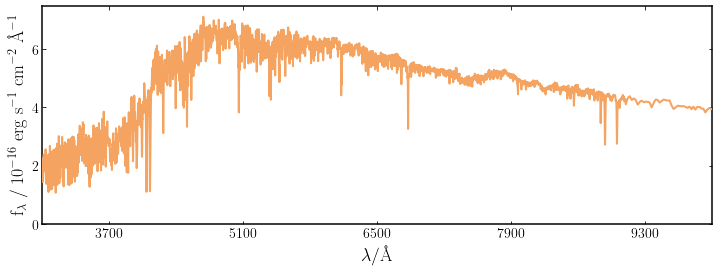

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-16}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [220]:
lognorm_model = pipes.model_galaxy(model_components, spec_wavs=obs_wavs)
lognorm_model.plot()

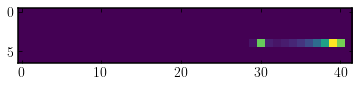

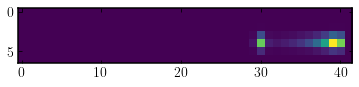

In [221]:
plt.imshow(baseline_model.sfh.ceh.grid)
plt.show()
plt.imshow(lognorm_model.sfh.ceh.grid)
plt.show()

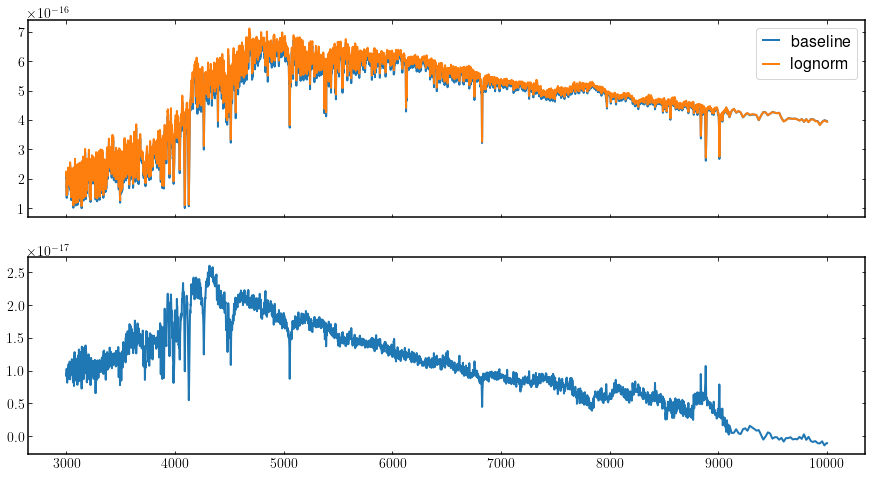

In [222]:
fig, ax = plt.subplots(2,1, figsize=[15,8], sharex=True)
ax[0].plot(obs_wavs, baseline_model.spectrum[:,1], label='baseline')
ax[0].plot(obs_wavs, lognorm_model.spectrum[:,1], label='lognorm')
ax[0].legend()
ax[1].plot(obs_wavs, lognorm_model.spectrum[:,1] - baseline_model.spectrum[:,1])
plt.show()

# Now we fit this mock spectrum

In [224]:
def mask_em(wave):
    """ from maskem.pro OII, Hgama, Hbeta, OIII, OIII: Vacuum """

    
    lines_vac = np.array([3727.092,3729.875,4102.892, 4341.692,4862.683,4960.295,5008.24])
    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        masksize = 5

        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    # MgII  2796.352 ,2803.531 
    #ind = np.where((wave>2766.4) & (wave<2833.5))

    # remove everything bluewards of 3000A
    ind = np.where(wave<3000)
    mask.extend(ind[0])    

    return mask

def load_uds_spectrum_mask_generated(ID,z):

    # load spectral data
    spectrum = lognorm_model.spectrum.copy()
    spectrum_noise = spectrum[:,1]/15
    spectrum = np.hstack([spectrum, np.expand_dims(spectrum_noise, axis=1)])

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.
    
    # nebular emission lines and interstellar absorption lines
    mask = mask_em(spectrum[:,0]/(1+z))
    spectrum[mask, 2] = 9.9*10**99.
    
    # O2 telluric
    mask = ((spectrum[:,0] > 7580.) & (spectrum[:,0] < 7650.))
    spectrum[mask, 2] = 9.9*10**99.

    #return bin(spectrum,4)
    return spectrum
    

def load_uds_mask_generated(ID):
    z = 0.04
    spectrum = load_uds_spectrum_mask_generated(ID,z)

    return spectrum

def get_fit_instructions(z=0.04):
    """ Set up the desired fit_instructions dictionary. """
    
    psb2 = {}
    psb2["age"] = (4, 14.)                     # Vary age between 4 Myr and 14 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.
    psb2["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
    psb2["massformed"] = (6, 13)              # vary log_10(M*/M_solar) between 1 and 15
    psb2["metallicity"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
    
    psb2["burstage"] = (0,2)                   # age of burst from 0 to 2Gyr
    psb2["alpha"] = (0.01,1000)               # decline of burst
    psb2["alpha_prior"] = "log_10"
    psb2["beta"] = 250.                    # rise of burst: fixed
    psb2["fburst"] = (0,1)
    
    fit_instructions = {}
    fit_instructions['psb_wild2020'] = psb2
    fit_instructions['redshift'] = (z-0.2*z, z+0.2*z)
    
    return fit_instructions

In [225]:
ID = 'lognorm_scatter_generated_psb_no_dust_no_noise_SNR15_recovary_test'
z = 0.04

galaxy = pipes.galaxy(ID, load_uds_mask_generated, photometry_exists=False)

fit_instructions = get_fit_instructions()
print(fit_instructions)

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'metallicity': (0.01, 2.5), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 250.0, 'fburst': (0, 1)}, 'redshift': (0.032, 0.048)}


In [226]:
pipes.config.Rspec = 4340
runID = "lognorm_scatter_generated_psb_no_dust_bin_by_1_4340_Rspec"
fit = pipes.fit(galaxy, fit_instructions, run=runID)

fit.fit(verbose=False)


Bagpipes: fitting object lognorm_scatter_generated_psb_no_dust_no_noise_SNR15_recovary_test


Completed in 4198.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
psb_wild2020:age               8.878     10.566     11.993
psb_wild2020:alpha           195.230    387.555    727.864
psb_wild2020:burstage          0.940      0.997      1.051
psb_wild2020:fburst            0.187      0.207      0.229
psb_wild2020:massformed        9.972      9.998     10.022
psb_wild2020:metallicity       0.966      1.011      1.057
psb_wild2020:tau               3.560      6.293      8.630
redshift                       0.040      0.040      0.040




In [227]:
def plot_spec(fit, ID, runID):

    # Make the figure
    matplotlib.rcParams.update({'font.size': 16})
    params = {'legend.fontsize': 16,
              'legend.handlelength': 1}
    matplotlib.rcParams.update(params)
    matplotlib.rcParams['text.usetex'] = True
    fit.posterior.get_advanced_quantities()

    naxes=1
    fig = plt.figure(figsize=(12, 5.*naxes))

    gs1 = matplotlib.gridspec.GridSpec(4, 1, hspace=0., wspace=0.)
    ax1 = plt.subplot(gs1[:3])
    ax3 = plt.subplot(gs1[3])

    mask = fit.galaxy.spectrum[:, 2] < 1.
    fit.galaxy.spectrum[mask, 2] = 0.

    y_scale = pipes.plotting.add_spectrum(fit.galaxy.spectrum, ax1)
    pipes.plotting.add_spectrum_posterior(fit, ax1, y_scale=y_scale)

    post_median = np.median(fit.posterior.samples["spectrum"], axis=0)

    #ax1.plot(fit.galaxy.spectrum[:,0],
    #         post_median*10**-y_scale,
    #         color="black", lw=1.0,zorder=11)

    ax3.axhline(0, color="black", ls="--", lw=1)
    ax3.plot(fit.galaxy.spectrum[:,0],(post_median - fit.galaxy.spectrum[:,1])*10**-y_scale, color="sandybrown")
    #ax1.set_xlim([3000,4200])
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
    ax3.set_ylabel('residual')
    fig.savefig('pipes/plots/'+runID+'/'+ID+'_fit.pdf')
    plt.show()
    
def integrate_sfh(ages, sfh, Mstar=None):
    """ 
    takes a sfh and integrates it to return a cumulative SFH (normalized to run from 0 to 1) fraction of 
    mass formed
    """
    if Mstar is None:
        Mstar = np.trapz(y=sfh,x=ages)
    c_sfh = np.zeros(len(sfh))
    for i,sfhi in enumerate(sfh):
        c_sfh[i] = np.trapz(sfh[:i+1],x=ages[:i+1]/Mstar)
    return c_sfh

# extracted from bagpipes.models.star_formation_history.py, with a bit of tweaking
def psb_wild2020(age_list, age, tau, burstage, alpha, beta, fburst, Mstar):
    """
    A 2-component SFH for post-starburst galaxies. An exponential
    compoent represents the existing stellar population before the
    starburst, while a double power law makes up the burst.
    The weight of mass formed between the two is controlled by a
    fburst factor: thefraction of mass formed in the burst.
    For more detail, see Wild et al. 2020
    (https://ui.adsabs.harvard.edu/abs/2020MNRAS.494..529W/abstract)
    """
    age_lhs = pipes.utils.make_bins(np.log10(age_list)+9, make_rhs=True)[0]
    age_list = age_list*10**9
    age_lhs = 10**age_lhs
    age_lhs[0] = 0.
    age_lhs[-1] = 10**9*pipes.utils.age_at_z[pipes.utils.z_array == 0.]
    age_widths = age_lhs[1:] - age_lhs[:-1]
    sfr = np.zeros(len(age_list))
    
    age_of_universe = 10**9*np.interp(0, pipes.utils.z_array,
                                               pipes.utils.age_at_z)
    
    age = age*10**9
    tau = tau*10**9
    burstage = burstage*10**9

    ind = (np.where((age_list < age) & (age_list > burstage)))[0]
    texp = age - age_list[ind]
    sfr_exp = np.exp(-texp/tau)
    sfr_exp_tot = np.sum(sfr_exp*age_widths[ind])

    mask = age_list < age_of_universe
    tburst = age_of_universe - age_list[mask]
    tau_plaw = age_of_universe - burstage
    sfr_burst = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr_burst_tot = np.sum(sfr_burst*age_widths[mask])

    sfr[ind] = (1-fburst) * np.exp(-texp/tau) / sfr_exp_tot

    dpl_form = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr[mask] += fburst * dpl_form / sfr_burst_tot
    
    return sfr*10**Mstar

def fit_f_burst(ages, sfh, age_at_z):
    # using scipy curve fit to get a fit to the true SFH
    popt,pcov = curve_fit(psb_wild2020, ages, sfh, 
                          bounds=([10,1,0,10,10,0,10],[13,10,2,1000,1000,1,12]))
    [age, tau, burstage, alpha, beta, fburst, Mstar] = popt
    tform = age_at_z - age
    tburst = age_at_z - burstage
    return fburst, tburst, tform, alpha, beta

def plot_sfh(fit, model_lookbacktime, model_sfh, ID, runID, model_f_burst=None, model_burstage=None):
    """
    Plots the regular SFH (SFR vs age of universe) plot on the top, cumulative SFH plot on the bottom
    """
    if 'redshift' in fit.posterior.samples.keys():
        post_z = np.median(fit.posterior.samples['redshift'])
    else: post_z = 0.04
    age_at_z = pipes.utils.cosmo.age(post_z).value

    #posterior sfh
    post_sfh = fit.posterior.samples['sfh']
    median_sfh = np.median(post_sfh,axis=0)
    age_of_universe = np.interp(post_z, pipes.utils.z_array, pipes.utils.age_at_z)
    post_ages = age_of_universe - fit.posterior.sfh.ages*10**-9
    post_ages_int = post_ages.copy()[::-1]*10**9
    post_m_total = np.trapz(y=median_sfh[::-1], x=post_ages_int)
    # integrate to get cumulative median
    c_median_sfh = integrate_sfh(post_ages_int, median_sfh[::-1], Mstar=post_m_total)

    #model sfh
    model_sfh = model_sfh.copy()
    model_ages = age_at_z-model_lookbacktime.copy()
    model_ages_int = model_ages.copy()[::-1]*10**9
    model_m_total = np.trapz(y=model_sfh[::-1], x=model_ages_int)
    # integrate to get cumulative of model sfh
    c_model_sfh = integrate_sfh(model_ages_int, model_sfh[::-1], Mstar=model_m_total)
    
    print('only recovered',post_m_total/model_m_total,'of total mass formed.')
    print(np.log10(post_m_total), np.log10(model_m_total))

    #calculating posterior tx and their uncertainties
    mass_percentiles = np.linspace(0,1,5)[1:-1]
    txs = []
    c_sfh_samples = []
    for sfh_sample in fit.posterior.samples['sfh']:
        sfh_ = sfh_sample[::-1]
        c_sfh_ = integrate_sfh(post_ages_int, sfh_)
        c_sfh_samples.append(c_sfh_)
        txs.append(np.interp(mass_percentiles, c_sfh_, post_ages_int))
    txs = (np.array(txs)/10**9).T
    tx_percentiles = []
    for i,txi in enumerate(txs):
        tx_percentiles.append(np.percentile(txi, (16,50,84)))
    tx_percentiles = np.array(tx_percentiles)
    #print(tx_percentiles)
    c_sfh_percentiles = np.percentile(c_sfh_samples, (16,50,84), axis=0)
    
    ################# plotting 
    
    fig, ax = plt.subplots(2,1, figsize=[15,10])
    pipes.plotting.add_sfh_posterior(fit, ax[0], z_axis=False)
    ax[0].plot(model_ages, model_sfh)
    ylim = ax[0].get_ylim()

    #calculate model burst fraction
    if model_f_burst is None and model_burstage is None:
        model_f_burst, model_t_burst, model_t_form, model_alpha, model_beta = fit_f_burst(
            model_lookbacktime.copy(), model_sfh, age_at_z)
    else:
        model_t_burst = age_at_z - model_burstage
    print('model f_burst and t_burst:',model_f_burst,model_t_burst)
    ax[0].vlines(model_t_burst, 0, ylim[1], color='red', ls='--')
    ax[0].arrow(age_at_z,ylim[1]*0.8,-(age_at_z-model_t_burst),0.0,color='red',head_width=np.max(ylim)/20., 
             head_length=0.1,length_includes_head=True)

    #use psb2's built in fburst and tburst posteriors to plot arrows
    post_f_burst = np.percentile(fit.posterior.samples['psb_wild2020:fburst'], (16,50,84))
    post_t_burst = age_of_universe-np.percentile(fit.posterior.samples['psb_wild2020:burstage'], (84,50,16))

    print('posterior f_burst and t_burst:',post_f_burst,post_t_burst)
    ax[0].vlines(post_t_burst[1], 0, ylim[1], color='sandybrown', ls='--')
    ax[0].arrow(age_of_universe,ylim[1]*0.9,-(age_of_universe-post_t_burst[1]),0.0,color='sandybrown',
             head_width=np.max(ylim)/20., head_length=0.1,length_includes_head=True)

    #plot vertical bands of tx percentiles
    for i,[l,m,u] in enumerate(tx_percentiles):
        ax[0].vlines(m, 0, 10*ylim[1], color = 'k', ls='--', alpha=0.5)
        ax[0].fill_betweenx([0,10*ylim[1]], l, u, facecolor='royalblue', alpha=(1.5-(i+1)/len(txs))/2.5)
    
    ax[0].set_ylim(ylim)
    #add text about z, age at z, poster f_burst and t_burst
    f_burst_r = [np.round(post_f_burst[1],2),np.round(post_f_burst[2]-post_f_burst[1],2),
                 np.round(post_f_burst[1]-post_f_burst[0],2)]
    f_burst_text = f'post f\_burst={f_burst_r[0]}+{f_burst_r[1]}-{f_burst_r[2]}\n '
    t_burst_r = [np.round(post_t_burst[1],2),np.round(post_t_burst[2]-post_t_burst[1],2),
                 np.round(post_t_burst[1]-post_t_burst[0],2)]
    t_burst_text = f'post t\_burst={t_burst_r[0]}+{t_burst_r[1]}-{t_burst_r[2]}Gyr \n '
    ax[0].text(0.03,0.6,
            f'redshift={np.round(post_z,3)}\n ' + 
            f'age at z={np.round(age_at_z,2)}Gyr\n ' + 
            f_burst_text + 
            f'true f\_burst={np.round(model_f_burst,2)}\n ' +
            t_burst_text +
            f'true t\_burst={np.round(model_t_burst,2)}Gyr',
            fontsize=14, transform=ax[0].transAxes, bbox=dict(boxstyle='round', facecolor='white'))
    
    ax[0].set_xlim(ax[0].get_xlim()[::-1])
    pipes.plotting.add_z_axis(ax[0])
    
    ax[1].plot(model_ages[::-1], c_model_sfh, zorder=1)
    ax[1].plot(post_ages[::-1], c_sfh_percentiles[1], color='k', zorder=1)
    ax[1].fill_between(post_ages[::-1], c_sfh_percentiles[0], c_sfh_percentiles[2], color='gray', 
                       alpha=0.6, zorder=0)
    ax[1].errorbar(tx_percentiles[:,1], np.linspace(0,1,5)[1:-1], xerr=[tx_percentiles[:,1]-tx_percentiles[:,0],
                                                                        tx_percentiles[:,2]-tx_percentiles[:,1]],
              color='red', label='calculated equivilent tx times (assuming 4 bins)', fmt='o', zorder=2)
    
    ax[1].set_xlim(ax[0].get_xlim())
    ax[1].set_ylim([0,1])
    ax[1].set_xlabel(ax[0].get_xlabel())
    ax[1].set_ylabel('fraction of cumulative mass formed')
    
    fig.savefig('pipes/plots/'+runID+'/'+ID+'_combined_sfh.pdf')
    plt.show()
    
    return fig,ax

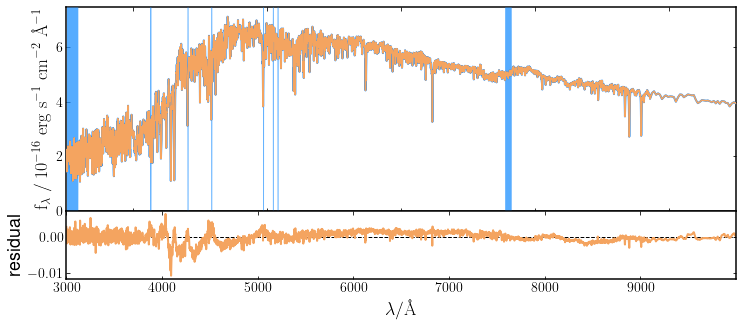

only recovered 0.8629487009036296 of total mass formed.
9.935986778178005 10.000001798889988
model f_burst and t_burst: 0.2 11.924075054579838
posterior f_burst and t_burst: [0.18736695 0.20790653 0.23084718] [11.87504997 11.92308117 11.98872162]


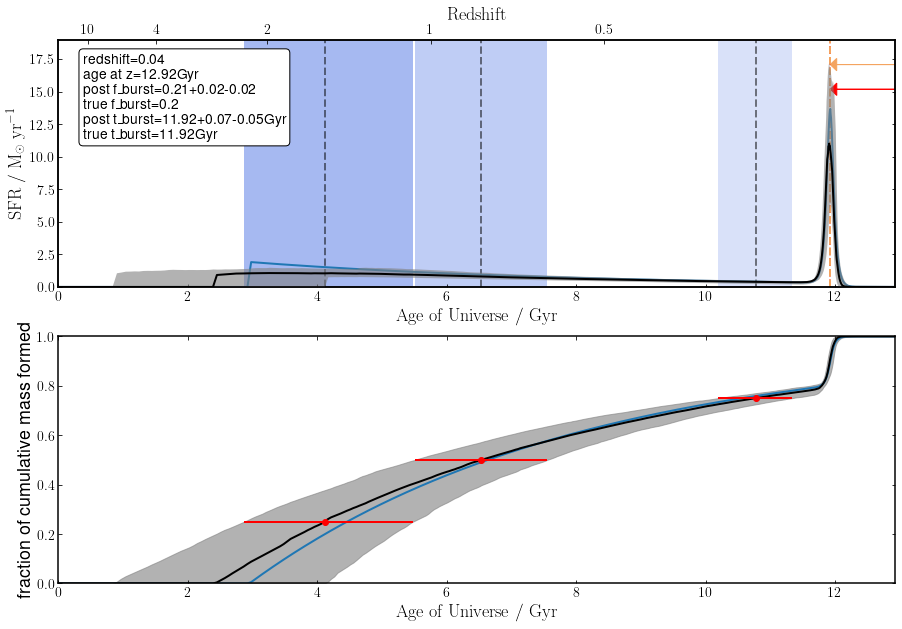

(<Figure size 1080x720 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>,
        <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='fraction of cumulative mass formed'>],
       dtype=object))

In [228]:
plot_spec(fit, ID, runID)
fig = fit.plot_corner(save=True, show=True)
plot_sfh(fit, lognorm_model.sfh.ages*10**-9, lognorm_model.sfh.sfh, ID, runID, 
         model_f_burst=model_components['psb_wild2020']['fburst'], 
         model_burstage=model_components['psb_wild2020']['burstage'])

## applying to Yirui's galaxy

In [229]:
def load_uds_spectrum_mask(ID,z):

    # load spectral data
    spectrum = np.loadtxt(fname='../../Yirui_test_cube/snap119/with_PSF/no_dust/Spectrum_'+
                          ID+".csv", delimiter=',', skiprows=1)
    
    spectrum[:,1] *= 10**-16
    spectrum[:,2] *= 10**-16

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.
    
    # nebular emission lines and interstellar absorption lines
    mask = mask_em(spectrum[:,0]/(1+z))
    spectrum[mask, 2] = 9.9*10**99.
    
    # O2 telluric
    mask = ((spectrum[:,0] > 7580.) & (spectrum[:,0] < 7650.))
    spectrum[mask, 2] = 9.9*10**99.

    #return bin(spectrum,4)
    return spectrum

def load_uds_mask(ID):
    z = 0.04
    spectrum = load_uds_spectrum_mask(ID,z)

    return spectrum

In [230]:
ID = '2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test'
z = 0.04

galaxy = pipes.galaxy(ID, load_uds_mask, photometry_exists=False)

fit_instructions = get_fit_instructions()
print(fit_instructions)

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'metallicity': (0.01, 2.5), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 250.0, 'fburst': (0, 1)}, 'redshift': (0.032, 0.048)}


In [231]:
pipes.config.Rspec = 4340
runID = "lognorm_scatter_yirui_no_dust_bin_by_1_4340_Rspec"
fit = pipes.fit(galaxy, fit_instructions, run=runID)

fit.fit(verbose=False)


Bagpipes: fitting object 2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test


Completed in 4496.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
psb_wild2020:age               6.001      7.499      9.388
psb_wild2020:alpha           144.440    154.660    167.898
psb_wild2020:burstage          0.572      0.607      0.640
psb_wild2020:fburst            0.232      0.251      0.269
psb_wild2020:massformed       10.649     10.681     10.719
psb_wild2020:metallicity       1.979      2.074      2.166
psb_wild2020:tau               3.718      6.716      8.921
redshift                       0.040      0.040      0.040




In [232]:
age_at_z = pipes.utils.cosmo.age(0).value
sim_data = np.loadtxt('../../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
model_sfh = sim_data[:,2]
model_ages = sim_data[:,0]
mask = model_ages > 0
model_ages = model_ages[mask].copy()
model_sfh = model_sfh[mask].copy()

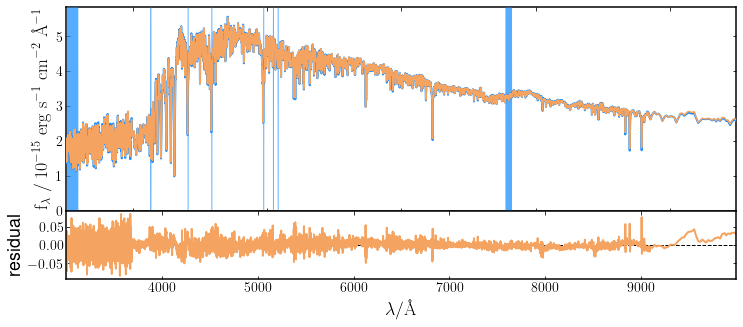

only recovered 0.40534218458263377 of total mass formed.
10.634223983928859 11.026402180142501
model f_burst and t_burst: 0.08993122012854099 12.374077934180223
posterior f_burst and t_burst: [0.23399621 0.25182259 0.26946897] [12.28586236 12.31881749 12.35240127]


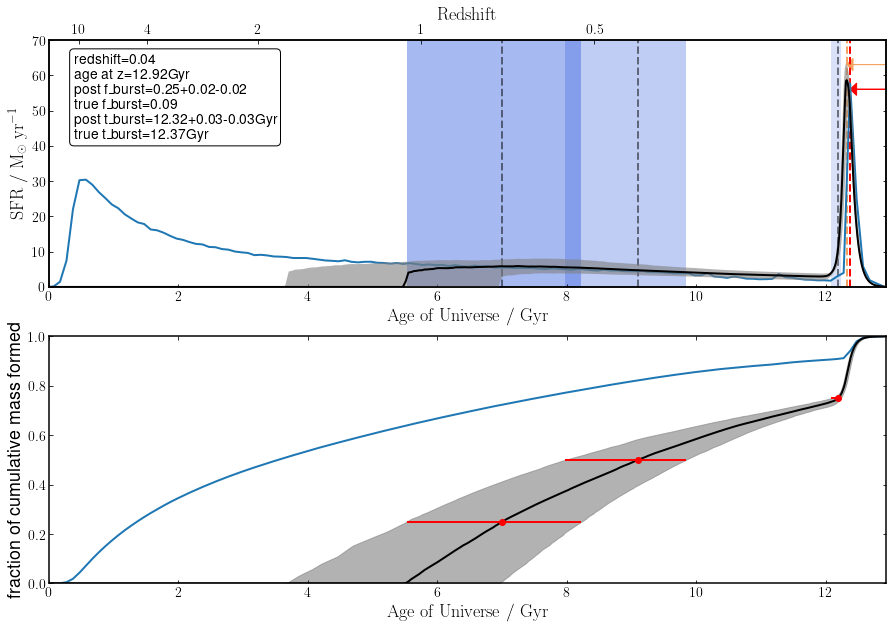

(<Figure size 1080x720 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>,
        <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='fraction of cumulative mass formed'>],
       dtype=object))

In [233]:
plot_spec(fit, ID, runID)
fig = fit.plot_corner(save=True, show=True)
plot_sfh(fit, model_ages, model_sfh, ID, runID)

## So that was not successful...
Metallicity ended up at 0.7, which is quite low. We need to combine 2step and lognormal.

In [234]:
def __init__(self, model_comp, sfh_weights):

    self.zmet_vals = config.metallicities
    self.zmet_lims = config.metallicity_bins

    self.grid_comp = {}
    self.grid = np.zeros((self.zmet_vals.shape[0],
                          config.age_sampling.shape[0]))

    for comp in list(sfh_weights):
        if comp is not "total":
            self.grid_comp[comp] = self.psb_two_step(model_comp[comp],
                                              sfh_weights[comp])

            self.grid += self.grid_comp[comp]
    global grid_comp 
    grid_comp = self.grid

def lognorm_(self, mean_zmet):
    """
    log normal metallicity distribution scatter. 
    Functional form: P(x) = 1/(x*sigma*np.sqrt(2*np.pi)) * np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
    where mu = ln(metallicity mean), sigma = some concentration measurement
    """
    log_mean_zmet = np.log(mean_zmet)
    sigma = 0.45

    weights = np.zeros(self.zmet_vals.shape[0])

    vals_hr = np.arange(0., 10., 0.01) + 0.005

    factors_hr = 1/(vals_hr*sigma*np.sqrt(2*np.pi)) * np.exp(-(np.log(vals_hr)-log_mean_zmet)**2/(2*sigma**2))

    for i in range(weights.shape[0]):
        lowmask = (vals_hr > self.zmet_lims[i])
        highmask = (vals_hr < self.zmet_lims[i+1])
        weights[i] = np.sum(0.01*factors_hr[lowmask & highmask])
        
    return weights

def psb_two_step(self, comp, sfh):
    """ 2-step metallicities (time-varying!) for psb SFH shape, shift at burstage """
    
    zmet_old = comp["metallicity_old"]
    zmet_burst = comp["metallicity_burst"]
    burstage = comp["burstage"]*10**9
    if "metallicity_scatter" not in comp.keys():
        scatter_func = self.delta_
    else:
        if comp["metallicity_scatter"] == 'delta':
            scatter_func = self.delta_
        elif comp["metallicity_scatter"] == 'exponential':
            scatter_func = self.exp_
        elif comp["metallicity_scatter"] == 'lognormal':
            scatter_func = self.lognorm_
    
    # get SSP ages
    SSP_ages = config.age_sampling
    SSP_age_bins = config.age_bins
    
    # loop through all SSP ages
    zmet_comp = np.zeros((self.zmet_vals.shape[0], sfh.shape[0]))
    for i,agei in enumerate(SSP_ages):
        # detect if the SSP age's higher boundary > tburst and lower boundary < tburst
        if SSP_age_bins[i+1]>burstage and SSP_age_bins[i]<burstage:
            # interp between to get metallicity at this SSP
            width = SSP_age_bins[i+1] - SSP_age_bins[i]
            old_weight = (SSP_age_bins[i+1] - burstage)/width
            burst_weight = (burstage - SSP_age_bins[i])/width
            SSP_zmet = old_weight*zmet_old + burst_weight*zmet_burst
            # interp metallicity (delta-style) to get weights with the interped metallicity
            zmet_comp[:,i] = scatter_func(SSP_zmet)
        
        # if before tburst
        elif SSP_age_bins[i]>burstage:
            # interp metallicity (delta-style) to get weights with the earlier metallicity
            zmet_comp[:,i] = scatter_func(zmet_old)
            
        # if after tburst
        elif SSP_age_bins[i+1]<burstage:
            # interp metallicity (delta-style) to get weights with the starburst metallicity
            zmet_comp[:,i] = scatter_func(zmet_burst)
            
        else:
            print('help')
    
    #print(zmet_comp)
    return zmet_comp*np.expand_dims(sfh, axis=0)

pipes.models.chemical_enrichment_history.__init__ = __init__
pipes.models.chemical_enrichment_history.lognorm_ = lognorm_
pipes.models.chemical_enrichment_history.psb_two_step = psb_two_step

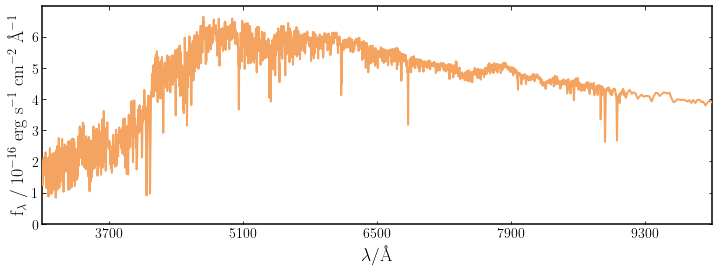

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-16}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [235]:
# toy model after adding 2 step
psb = {}
psb['massformed'] = 10
psb['metallicity_old'] = 1.0
psb['metallicity_burst'] = 2.0
psb['metallicity_scatter'] = 'lognormal'
psb['age'] = 10
psb['tau'] = 5
psb['burstage'] = 1
psb['alpha'] = 250
psb['beta'] = 250
psb['fburst'] = 0.2

model_components2 = {}
model_components2['psb_wild2020'] = psb
model_components2['redshift'] = 0.04

twostep_lognorm_model = pipes.model_galaxy(model_components2, spec_wavs=obs_wavs)
twostep_lognorm_model.plot()

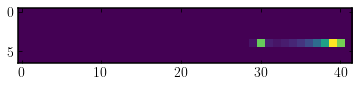

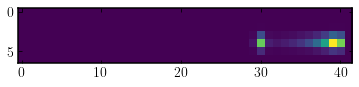

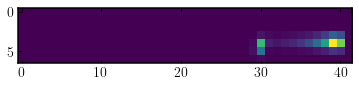

In [236]:
plt.imshow(baseline_model.sfh.ceh.grid)
plt.show()
plt.imshow(lognorm_model.sfh.ceh.grid)
plt.show()
plt.imshow(twostep_lognorm_model.sfh.ceh.grid)
plt.show()

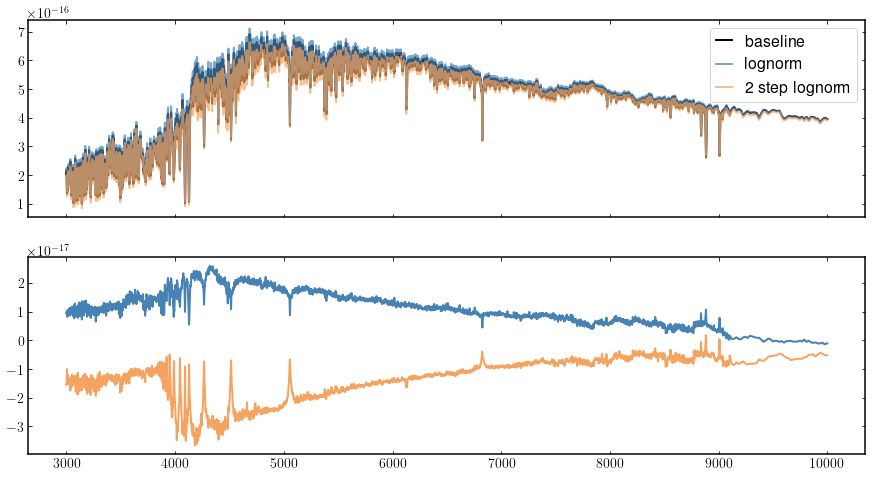

In [237]:
fig, ax = plt.subplots(2,1, figsize=[15,8], sharex=True)
ax[0].plot(obs_wavs, baseline_model.spectrum[:,1], label='baseline', color='black')
ax[0].plot(obs_wavs, lognorm_model.spectrum[:,1], label='lognorm', color='steelblue', alpha=0.7)
ax[0].plot(obs_wavs, twostep_lognorm_model.spectrum[:,1], label='2 step lognorm', color='sandybrown', alpha=0.7)
ax[0].legend()
ax[1].plot(obs_wavs, lognorm_model.spectrum[:,1] - baseline_model.spectrum[:,1], color='steelblue')
ax[1].plot(obs_wavs, twostep_lognorm_model.spectrum[:,1] - baseline_model.spectrum[:,1], color='sandybrown')

plt.show()

In [249]:
# jumping forward to fitting Yirui's simulation directly
def get_fit_instructions_twostep_lognorm(z=0.04):
    """ Set up the desired fit_instructions dictionary. """
    
    psb2 = {}
    psb2["age"] = (4, 14.)                     # Vary age between 4 Myr and 14 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.
    psb2["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
    psb2["massformed"] = (6, 13)              # vary log_10(M*/M_solar) between 1 and 15
    psb2["metallicity_old"] = (0.01, 3.5)           # vary Z between 0.1 and 2.5 Z_solar
    psb2["metallicity_old_prior"] = "log_10"
    psb2["metallicity_burst"] = (0.01, 3.5)
    psb2["metallicity_burst_prior"] = "log_10"
    psb2["metallicity_scatter"] = "lognormal"
    
    psb2["burstage"] = (0,2)                   # age of burst from 0 to 2Gyr
    psb2["alpha"] = (0.01,1000)               # decline of burst
    psb2["alpha_prior"] = "log_10"
    psb2["beta"] = 250.                    # rise of burst: fixed
    psb2["fburst"] = (0,1)
    
    fit_instructions = {}
    fit_instructions['psb_wild2020'] = psb2
    fit_instructions['redshift'] = (z-0.2*z, z+0.2*z)
    
    return fit_instructions

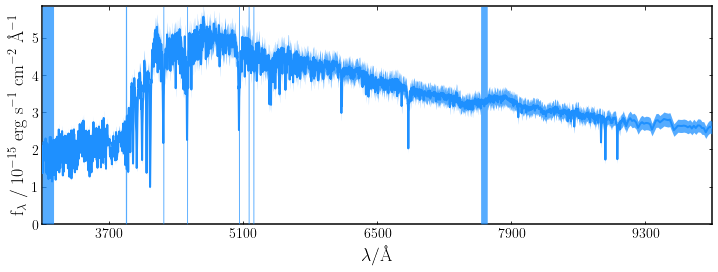

In [250]:
ID = '2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test'
z = 0.04

galaxy = pipes.galaxy(ID, load_uds_mask, photometry_exists=False)

fig = galaxy.plot()

In [251]:
fit_instructions = get_fit_instructions_twostep_lognorm()
print(fit_instructions)

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'metallicity_old': (0.01, 3.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 3.5), 'metallicity_burst_prior': 'log_10', 'metallicity_scatter': 'lognormal', 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 250.0, 'fburst': (0, 1)}, 'redshift': (0.032, 0.048)}


In [252]:
pipes.config.Rspec = 4340
runID = "two_step_lognorm_metallicity_yirui2_no_dust_bin_by_1_4340_Rspec"
fit = pipes.fit(galaxy, fit_instructions, run=runID)

fit.fit(verbose=False)


Bagpipes: fitting object 2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test


Completed in 10414.4 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
psb_wild2020:age               6.849      8.726     11.083
psb_wild2020:alpha           144.746    155.362    173.689
psb_wild2020:burstage          0.557      0.601      0.634
psb_wild2020:fburst            0.207      0.226      0.250
psb_wild2020:massformed       10.677     10.719     10.761
psb_wild2020:metallicity_burst      2.194      2.415      2.628
psb_wild2020:metallicity_old      1.417      1.643      1.884
psb_wild2020:tau               2.928      5.911      8.683
redshift                       0.040      0.040      0.040




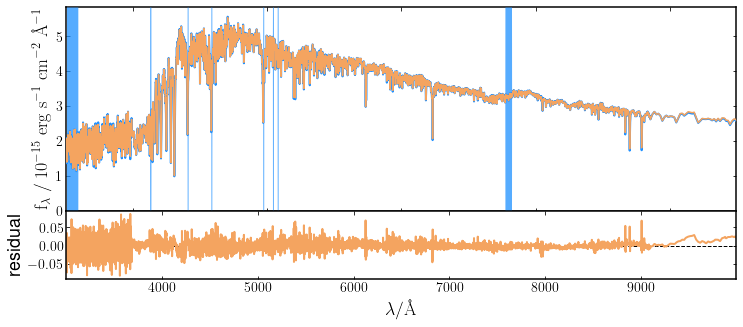

only recovered 0.42366025897726367 of total mass formed.
10.653419907498812 11.026402180142501
model f_burst and t_burst: 0.08993122012854099 12.374076911726286
posterior f_burst and t_burst: [0.20859942 0.22587862 0.2483426 ] [12.29128106 12.32126418 12.36499292]


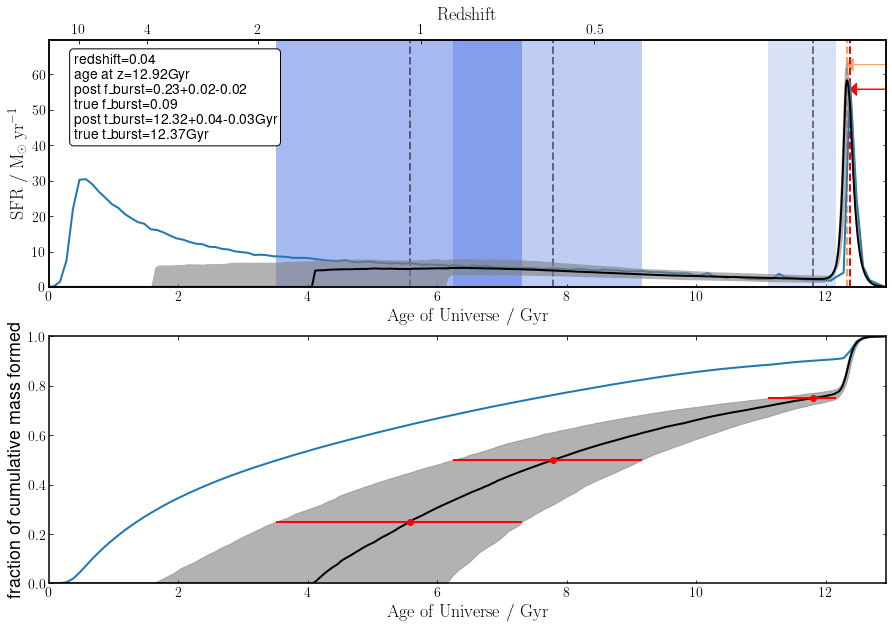

(<Figure size 1080x720 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>,
        <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='fraction of cumulative mass formed'>],
       dtype=object))

In [253]:
plot_spec(fit, ID, runID)
fig = fit.plot_corner(save=True, show=True)
plot_sfh(fit, model_ages, model_sfh, ID, runID)

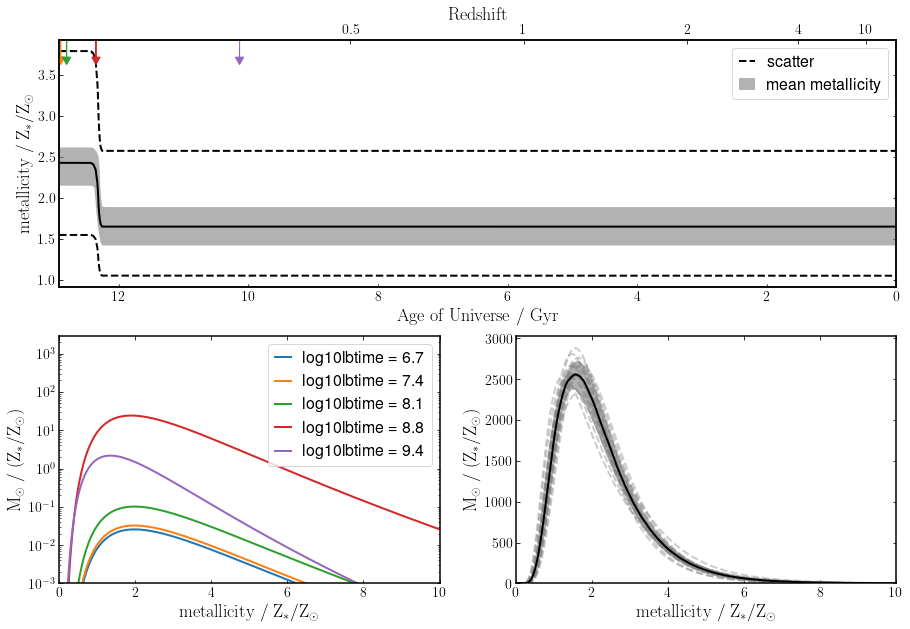

In [254]:
def lognorm_plot(mean_zmet, x=np.arange(0., 10., 0.01) + 0.005):
    log_mean_zmet = np.log(mean_zmet)
    sigma = 0.45
    if 'array' in str(type(mean_zmet)):
        log_mean_zmet = np.expand_dims(log_mean_zmet, axis=1)
    pdf = 1/(x*sigma*np.sqrt(2*np.pi)) * np.exp(-(np.log(x)-log_mean_zmet)**2/(2*sigma**2))
    return pdf

vlognorm_plot = np.vectorize(lognorm_plot)

def get_ceh(self):
    self.samples["ceh"] = np.zeros((self.n_samples, len(self.sfh.ages)))
    for i in range(self.n_samples):
        for j in range(len(self.sfh.ages)):
            if self.sfh.ages[j] > self.samples['psb_wild2020:burstage'][i]*10**9:
                self.samples["ceh"][i,j] = self.samples['psb_wild2020:metallicity_old'][i]
            else:
                self.samples["ceh"][i,j] = self.samples['psb_wild2020:metallicity_burst'][i]

pipes.fitting.posterior.get_ceh = get_ceh
                
def plot_ceh_posterior(fit, z_axis=True, zvals=[0, 0.5, 1, 2, 4, 10]):
    import bagpipes.utils as utils
    from bagpipes.plotting.general import add_z_axis,tex_on
    fit.posterior.get_ceh()
    
    fig = plt.figure(figsize=[15,10])
    gs = matplotlib.gridspec.GridSpec(2,2)
    mainax = plt.subplot(gs[0,:])
    leftax = plt.subplot(gs[1,0])
    rightax = plt.subplot(gs[1,1])
    
    # Calculate median redshift and median age of Universe
    if "redshift" in fit.fitted_model.params:
        redshift = np.median(fit.posterior.samples["redshift"])

    else:
        redshift = fit.fitted_model.model_components["redshift"]

    age_of_universe = np.interp(redshift, utils.z_array, utils.age_at_z)

    # Calculate median and confidence interval for mean metallicity posterior
    mean_zmet_percentiles = np.percentile(fit.posterior.samples['ceh'], (16,50,84), axis=0).T

    # Plot the CEH
    x = age_of_universe - fit.posterior.sfh.ages*10**-9

    mainax.plot(x, mean_zmet_percentiles[:, 1], color='black', zorder=4+1)
    mainax.fill_between(x, mean_zmet_percentiles[:, 0], mean_zmet_percentiles[:, 2], 
                        color='gray',
                        alpha=0.6, zorder=4, lw=0, label='mean metallicity')
    
    # dotted lines showing 16th and 84th percentile of scatter distribution across time if assuming
    # mean metallicity = posterior median
    zmet_sampling = np.arange(0., 10., 0.01) + 0.005
    scatter_percentiles = np.zeros([len(x), 3])
    for i,median_zmet in enumerate(mean_zmet_percentiles[:,1]):
        pdf = lognorm_plot(median_zmet, x=zmet_sampling)
        scatter_percentile = np.interp([0.16,0.50,0.84], np.cumsum(pdf)*0.01, zmet_sampling)
        scatter_percentiles[i] = scatter_percentile
    mainax.plot(x, scatter_percentiles[:, 0], color='black', ls='--', zorder=4+1, label='scatter')
    mainax.plot(x, scatter_percentiles[:, 2], color='black', ls='--', zorder=4+1)
    
    #ax.set_ylim(0., np.max([ax.get_ylim()[1], 1.1*np.max(post[:, 2])]))
    mainax.set_xlim(age_of_universe, 0)

    # Add redshift axis along the top
    if z_axis:
        ax2 = add_z_axis(mainax, zvals=zvals)

    # Set axis labels
    if tex_on:
        mainax.set_ylabel("$\\mathrm{metallicity\\ /\\ Z_* / Z_{\\odot}}$")
        mainax.set_xlabel("$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$")

    else:
        mainax.set_ylabel("metallicity / Z*/Z_sol")
        mainax.set_xlabel("Age of Universe / Gyr")
    mainax.legend()
    
    # bottom left plot: scatter cross sections
    n = 5
    ind = np.round(np.linspace(0, len(fit.posterior.sfh.ages)-1, n+2)).astype(int)[1:-1]
    main_ylims = mainax.get_ylim()
    for i in ind:
        this_mean_zmet = mean_zmet_percentiles[:,1][i]
        pdf = lognorm_plot(this_mean_zmet, x=zmet_sampling)
        # multiply by SFR at that age bin
        stellar_mass_dist = pdf * fit.posterior.sfh.sfh[i]
        p0 = leftax.plot(zmet_sampling, stellar_mass_dist, 
                         label='log10lbtime = '+str(np.round(np.log10(fit.posterior.sfh.ages[i]),1)))
        # add arrow to main plot to show when the cross sections are
        mainax.arrow(x[i], main_ylims[1], 0.0, -0.1*np.diff(main_ylims)[0],
                     color=p0[0].get_color(),head_width=0.01*np.diff(mainax.get_xlim())[0], 
                     head_length=0.3*0.1*np.diff(main_ylims)[0],length_includes_head=True, zorder=4+2)
    
    mainax.set_ylim(main_ylims)
    leftax.set_xlabel("$\\mathrm{metallicity\\ /\\ Z_* / Z_{\\odot}}$")
    leftax.set_ylabel("$\\mathrm{M_\\odot\\ /\\ (Z_* / Z_{\\odot})}$")
    leftax.set_xlim(0,10)
    leftax.legend()
    leftax.set_yscale('log')
    leftax.set_ylim(bottom=10**-3)
    
    # bottom right plot: total scatter distribution
    all_samp_scatters = np.zeros([fit.posterior.n_samples, len(zmet_sampling)])
    for i in range(fit.posterior.n_samples):
        samp_mean_zmet = fit.posterior.samples['ceh'][i]
        samp_pdf = lognorm_plot(samp_mean_zmet)
        samp_stellar_mass_dist = np.expand_dims(fit.posterior.samples['sfh'][i], axis=1)*samp_pdf
        samp_summed_stellar_mass_dist = np.sum(samp_stellar_mass_dist, axis=0)
        all_samp_scatters[i] = samp_summed_stellar_mass_dist
    int_scatter_percentile = np.percentile(all_samp_scatters, (16,50,84), axis=0).T
    rightax.plot(zmet_sampling, int_scatter_percentile[:,1], color='black', zorder=4+1)
    rightax.fill_between(zmet_sampling, int_scatter_percentile[:,0], int_scatter_percentile[:,2],
                        color='gray', alpha=0.6, zorder=4, lw=0)
    rand_inds = np.random.randint(fit.posterior.n_samples, size=20)
    for randi in rand_inds:
        rightax.plot(zmet_sampling, all_samp_scatters[randi], color='gray', alpha=0.4, ls='--')
    
    rightax.set_xlabel("$\\mathrm{metallicity\\ /\\ Z_* / Z_{\\odot}}$")
    rightax.set_ylabel("$\\mathrm{M_\\odot\\ /\\ (Z_* / Z_{\\odot})}$")
    rightax.set_xlim(0,10)
    rightax.set_ylim(bottom=0)
    plt.show()
    
plot_ceh_posterior(fit)

In [200]:
x = np.arange(0., 10., 0.01) + 0.005
mean_zmet = np.array([2,1])
sigma = 0.4
x = np.expand_dims(x, axis=1)
pdf = 1/(x*sigma*np.sqrt(2*np.pi)) * np.exp(-(np.log(x)-mean_zmet)**2/(2*sigma**2))

In [215]:
np.random.randint(fit.posterior.n_samples, size=20)

array([440, 420,  85,   8, 277, 387, 474, 291, 409, 261, 127, 465, 228,
       431, 264,  70, 382, 198, 252, 396])

[1.73257755 2.71328291 4.24749968]


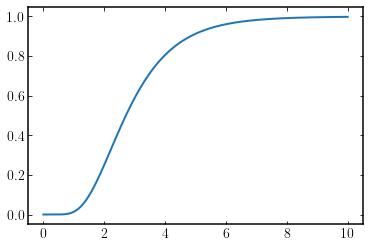

In [105]:
x = np.arange(0., 10., 0.01) + 0.005
pdf = lognorm_plot(1)
percentiles = np.cumsum(pdf)*0.01
print(np.interp([0.16,0.50,0.84], percentiles, x))
plt.plot(x, percentiles)

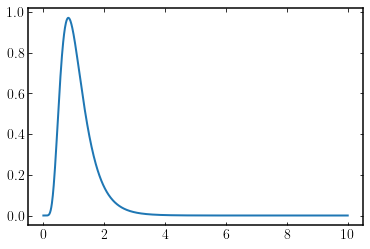

In [117]:
plt.plot(x, lognorm_plot(0.01))

In [87]:
fit.posterior.samples['ceh']

array([[0.80931441, 0.80931441, 0.80931441, ..., 0.48872966, 0.48872966,
        0.48872966],
       [1.00084112, 1.00084112, 1.00084112, ..., 0.27231334, 0.27231334,
        0.27231334],
       [0.84950752, 0.84950752, 0.84950752, ..., 0.56378047, 0.56378047,
        0.56378047],
       ...,
       [0.8102591 , 0.8102591 , 0.8102591 , ..., 0.46052951, 0.46052951,
        0.46052951],
       [0.75937049, 0.75937049, 0.75937049, ..., 0.85955964, 0.85955964,
        0.85955964],
       [0.83285715, 0.83285715, 0.83285715, ..., 0.51736642, 0.51736642,
        0.51736642]])

In [86]:
fit.posterior.get_ceh()

In [64]:
fit.posterior.sfh.ages

array([1.00000000e+06, 1.00577306e+06, 1.01157945e+06, ...,
       1.34121994e+10, 1.34896288e+10, 1.35675053e+10])

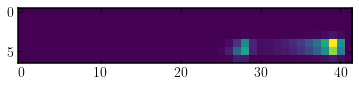

In [55]:
plt.imshow(fit.posterior.sfh.ceh.grid)
plt.show()

In [47]:
help(fig.Gridspec)

AttributeError: 'Figure' object has no attribute 'Gridspec'